# STTMALST Gastrointestinal-Cancer-MSI-MSS-Prediction

**Project created and conducted by: Christopher Bernold and Ellen Þórðardóttir**

_Fall 2020_

Reference list and inspriation links:

https://www.tensorflow.org/tutorials/load_data/images

https://www.tensorflow.org/api_docs/python/tf/data/Dataset#top_of_page



In [12]:
#inspired by https://www.tensorflow.org/tutorials/load_data/images
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.python.client import device_lib
import pathlib 

In [ ]:
#Globals
#batch_size = 10000
epochs = 100
img_heightr, img_width = 28,28

Specifying tensorflow to use a GPU but only allocate memory from GPU when needed. 

_Currently broken as tensorflow does not always detect NVIDIA RTX GPU's, searching for solution._

In [13]:
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
tf.compat.v1.Session
print("Tensorflow version: ",tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print(device_lib.list_local_devices())

Tensorflow version:  2.5.0-dev20201217
Num GPUs Available:  0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10960476265203866964
]


In [14]:
DATA_PATH = './tcga_coad_msi_mss'
data_dir = pathlib.Path(DATA_PATH)

In [15]:
#Gets all images in all dataset folders
image_count = len(list(data_dir.glob('*/*/*.jpg')))
print("Total amount of images is: ", image_count)

Total amount of images is:  192312


In [16]:
train_MSS, train_MSIMUT = list(data_dir.glob('train/MSS/*')), list(data_dir.glob('train/MSIMUT/*'))
test_MSS, test_MSIMUT = list(data_dir.glob('test/MSS/*')), list(data_dir.glob('test/MSIMUT/*'))
val_MSS, val_MSIMUT  = list(data_dir.glob('val/MSS/*')), list(data_dir.glob('val/MSIMUT/*'))

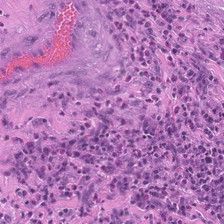

In [17]:
PIL.Image.open(str(train_MSS[0]))

In [18]:
image_details = PIL.Image.open(str(train_MSIMUT[0]))
width, height = image_details.size
batch_size = 1000
print("Width:" , width , ", Height:" , height , ", Batch size:" , batch_size)

Width: 224 , Height: 224 , Batch size: 1000


Specifying dataset folder locations. Data is already split up into train test and validation set, <br>
 meaning that we do not need to create a 80/20 split for the training and validation set.

In [19]:
training_set_dir = os.path.join(DATA_PATH, 'train')
training_root = pathlib.Path(training_set_dir)

test_set_dir = os.path.join(DATA_PATH, 'test')
test_root = pathlib.Path(test_set_dir)

validation_set_dir = os.path.join(DATA_PATH,'val')
validation_root = pathlib.Path(validation_set_dir)

train_MSIMUT_dir = os.path.join(training_set_dir, 'MSIMUT')
train_MSS_dir = os.path.join(training_set_dir, 'MSS')

test_MSIMUT_dir = os.path.join(test_set_dir, 'MSIMUT')
test_MSS_dir = os.path.join(test_set_dir, 'MSS')

validation_MSIMUT_dir = os.path.join(validation_set_dir, 'MSIMUT')
validation_MSS_dir = os.path.join(validation_set_dir, 'MSS')

In [20]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(training_root,
 seed=43110,
  image_size=(height,width),
   batch_size=batch_size,
    shuffle=True,
     color_mode='grayscale', label_mode='int')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_root,
 seed=43110,
  image_size=(height,width),
   batch_size=batch_size,
    shuffle=True,
     color_mode='grayscale')
val_ds = tf.keras.preprocessing.image_dataset_from_directory(validation_root,
 seed=43110,
  image_size=(height,width),
   batch_size=batch_size,
    shuffle=True,
     color_mode='grayscale')

Found 153849 files belonging to 2 classes.
Found 19233 files belonging to 2 classes.
Found 19230 files belonging to 2 classes.


In [22]:
class_names = train_ds.class_names
print(class_names)

['MSIMUT', 'MSS']


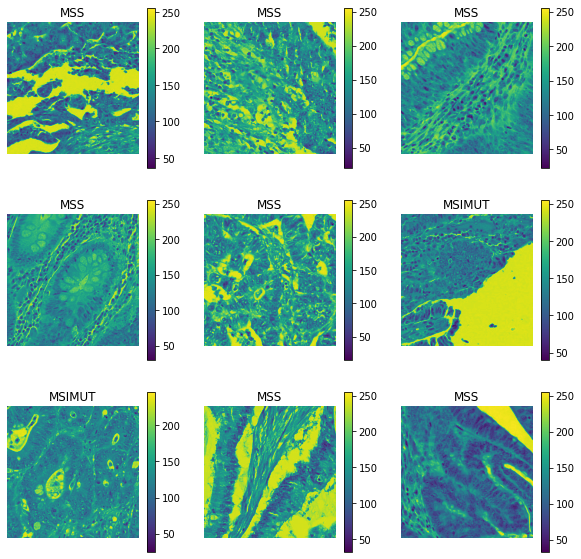

In [23]:
#Takes 9 random images from training set displaying MSS and MSIMUT images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.colorbar()
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [31]:
#Shape is 224(height)x(width)x1(RGB color channels == greyscale)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(1000, 224, 224, 1)
(1000,)


DO NOT RUN CELL BELOW UNLESS NEEDED!!!

In [24]:
for x, y in train_ds:
    X_train = images.numpy()
    y_train = labels.numpy()

In [27]:
print('Training data: Minimum RGB value: %.3f, Maximum RGB value: %.3f' % (X_train.min(), X_train.max()))

Training data: Minimum RGB value: 0.000, Maximum RGB value: 255.000


In [29]:
#Scaling the data from 255/0 to 0/1.
X_train = X_train/255.0

In [30]:

y_train

(1000, 224, 224, 1)

In [72]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [73]:
#Specifying the number of classes found in the dataset.
num_classes = len(class_names)
print(num_classes)

2


In [74]:
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D()
])

TypeError: __init__() missing 2 required positional arguments: 'filters' and 'kernel_size'